Feature Selection is one of the core concepts in machine learning which hugely impacts the performance of the model.

Identifying the related features from a set of data and removing the irrelevant or less important features with do not contribute much to the target variable in order to achieve better accuracy for the model.

In [100]:
!pip install catboost

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from catboost import CatBoostRegressor

from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,log_loss
from sklearn.metrics import mean_squared_error

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Files/sample_submission.csv')
train_data

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.000,9.545,9.265,8.110,8.430,7.150,0.180,...,4.950,1.730,1.800,4.800,3.150,10.665,10.465,16.645,5.750,10.37
1,1,9.10,13.533,40.900,8.770,9.265,6.015,10.070,7.150,1.107,...,20.050,9.530,7.695,4.550,6.950,2.040,5.200,5.725,2.950,2.23
2,2,8.21,3.710,5.420,8.770,9.265,4.550,10.070,7.150,0.020,...,4.580,3.025,3.960,4.935,4.950,4.725,6.075,6.750,3.500,3.17
3,3,8.39,8.700,8.100,9.500,9.200,5.200,8.670,6.670,0.280,...,8.450,2.070,1.730,6.300,4.700,3.500,6.200,8.670,2.900,7.37
4,4,8.07,8.050,8.650,7.960,9.265,3.290,10.070,7.150,0.360,...,2.020,1.730,0.760,4.800,4.970,3.950,2.800,8.400,3.500,3.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,8.08,6.250,8.300,7.795,9.265,5.690,8.555,6.335,0.565,...,14.575,0.636,1.640,4.235,4.100,2.800,3.950,7.695,3.540,2.50
3496,3496,8.09,6.630,6.630,8.370,7.600,0.636,8.430,7.150,1.300,...,4.580,1.730,1.800,4.900,3.150,2.040,6.075,8.415,2.155,2.90
3497,3497,9.95,8.367,8.433,8.770,6.170,5.800,10.400,7.200,0.430,...,20.050,1.440,1.800,4.867,4.833,4.725,4.950,8.400,6.625,4.20
3498,3498,9.52,10.000,6.630,9.545,9.265,3.290,8.980,2.310,0.300,...,20.050,9.530,7.695,10.700,5.400,4.725,3.300,6.750,6.625,5.00


In [104]:
is_null = train_data.isnull().sum()
is_null[is_null > 0]

,0


In [105]:
# Process trainData to fill up null, drop unused columns that are not present in test dataset
def generateXY(df):
    x = df.drop(columns=['id','target'])
    y = df.target
    return x,y

### Filter Method

Filter and take only the subset of the relevant features. The model is built after selecting the features. The filtering here is done using correlation matrix.

In [106]:
# Discover features with high correlation, and keep and drop the other. Same process is followed until last variable.
columns = train_data.columns.tolist()
highCorrFeature = []
for i in range(5,len(columns)):
    if columns[i] in highCorrFeature:
        continue
    for j in range(i,len(columns)):
        if columns[j] in highCorrFeature:
            continue
        if i != j:
            c = train_data[columns[i]].corr(train_data[columns[j]])
            if c > 0.5:
                print(f"{columns[i]} and {columns[j]} has high correlation {c}")
                highCorrFeature.append(columns[j])



NH4_1 and NH4_2 has high correlation 0.8414882929192141
NO3_1 and NO3_2 has high correlation 0.7196981136988064
NO3_3 and NO3_5 has high correlation 0.5421141239762864
NO3_3 and NO3_6 has high correlation 0.6412964900302395
NO3_3 and NO3_7 has high correlation 0.5560658153589095
BOD5_1 and BOD5_2 has high correlation 0.6448950380251331
BOD5_6 and BOD5_7 has high correlation 0.5551490469957161


In [107]:
highCorrFeature

['NH4_2', 'NO3_2', 'NO3_5', 'NO3_6', 'NO3_7', 'BOD5_2', 'BOD5_7']

In [108]:
# Pearson Correlation

# drop features with high correlation
data_corr = train_data.drop(columns=highCorrFeature)
featurePC = data_corr.columns.tolist()
print("Selected features: ",featurePC)

Selected features:  ['id', 'target', 'O2_1', 'O2_2', 'O2_3', 'O2_4', 'O2_5', 'O2_6', 'O2_7', 'NH4_1', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NH4_7', 'NO2_1', 'NO2_2', 'NO2_3', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7', 'NO3_1', 'NO3_3', 'NO3_4', 'BOD5_1', 'BOD5_3', 'BOD5_4', 'BOD5_5', 'BOD5_6']


In [109]:
data_corr.columns

Index(['id', 'target', 'O2_1', 'O2_2', 'O2_3', 'O2_4', 'O2_5', 'O2_6', 'O2_7',
       'NH4_1', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NH4_7', 'NO2_1', 'NO2_2',
       'NO2_3', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7', 'NO3_1', 'NO3_3', 'NO3_4',
       'BOD5_1', 'BOD5_3', 'BOD5_4', 'BOD5_5', 'BOD5_6'],
      dtype='object')

In [110]:
# generate data
X_corr,y_corr = generateXY(data_corr)

#train-test split
X_train_corr, X_val_corr, y_train_corr, y_val_corr = train_test_split(X_corr, y_corr, test_size=0.2, random_state=42)

#Random Forest Regression works by creating multiple of decision trees each trained on a random subset of the data.

#create model
model_corr = RandomForestRegressor(n_estimators=1000, max_depth=7, n_jobs=-1, random_state=42)

#fit model
model_corr.fit(X_train_corr, y_train_corr)

#predict
prediction_corr = model_corr.predict(X_val_corr)
loss_corr = mean_squared_error(y_val_corr, prediction_corr)
print(f"Pearson Correlation has RMSE = {loss_corr}")


Pearson Correlation has RMSE = 1.304404453410798


### Wrapped Method

Step Forward Selection

Step forward selection starts with the evaluation of each individual feature, and selects that which results in the best performing selected algorithm model.

Start with having no feature in the model. In each iteration, keep adding the feature which best improves the model till an addition of a new variable does not improve the performance of the model.

In [111]:
X_cat, y_cat = generateXY(train_data)
X_cat.columns

Index(['O2_1', 'O2_2', 'O2_3', 'O2_4', 'O2_5', 'O2_6', 'O2_7', 'NH4_1',
       'NH4_2', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NH4_7', 'NO2_1', 'NO2_2',
       'NO2_3', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7', 'NO3_1', 'NO3_2', 'NO3_3',
       'NO3_4', 'NO3_5', 'NO3_6', 'NO3_7', 'BOD5_1', 'BOD5_2', 'BOD5_3',
       'BOD5_4', 'BOD5_5', 'BOD5_6', 'BOD5_7'],
      dtype='object')

In [112]:
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)

#CatBoost is an ensemble learning technique that combines the strengths of multiple weak learners to produce a predictive model

#create model
model_cat = CatBoostRegressor(iterations=10, metric_period=500, verbose=False)

In [113]:
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import warnings

warnings.filterwarnings('ignore')

# build step forward feature selection
sf_sel = sfs(model_cat ,k_features=5, forward=True, floating=False, verbose=1, cv=3)
#perform SFFS
sf_sel = sf_sel.fit(X_train_cat, y_train_cat)

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    4.2s finished
Features: 1/5[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    4.2s finished
Features: 2/5[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    4.2s finished
Features: 3/5[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    5.7s finished
Features: 4/5[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    4.6s finished
Features: 5/5

In [114]:
# indexes of most important features
feat_cols = list(sf_sel.k_feature_idx_)
feat_cols

[0, 1, 3, 4, 30]

In [115]:
# most important features
featureSFS = X_cat.columns[feat_cols].tolist()
featureSFS

['O2_1', 'O2_2', 'O2_4', 'O2_5', 'BOD5_3']

In [116]:
X_sfs = X_cat[featureSFS]
y_sfs = y_cat

X_sfs.columns

Index(['O2_1', 'O2_2', 'O2_4', 'O2_5', 'BOD5_3'], dtype='object')

In [117]:
X_train_sfs, X_val_sfs, y_train_sfs, y_val_sfs = train_test_split(X_sfs, y_sfs, test_size=0.2, random_state=42)

In [118]:
#create model
model_sfs = RandomForestRegressor(n_estimators=1000, max_depth=7, n_jobs=-1, random_state=42)

#fit model
model_sfs.fit(X_train_sfs, y_train_sfs)

#predict
prediction_sfs = model_sfs.predict(X_val_sfs)
loss_sfs = mean_squared_error(y_val_sfs, prediction_sfs)
print(f"Step forward selection has RMSE = {loss_sfs}")

Step forward selection has RMSE = 1.5245634371370784


### Embedded Method

Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration.

Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

Lasso regularization:

If the feature is irrelevant, lasso penalizes its coefficient and make it 0.

Hence the features with coefficient = 0 are removed and the rest are taken.

In [119]:
from sklearn.linear_model import LassoCV

X_lasso, y_lasso = generateXY(train_data)

# fit LassoCV model
# (cv=5) 5-fold cross-validation
model_lassoCV = LassoCV(cv=5, n_alphas=200, tol=1e-4, fit_intercept=False)
model_lassoCV.fit(X_lasso, y_lasso)

# coefficient of determination on test data
print("Best score: ", model_lassoCV.score(X_lasso, y_lasso))

Best score:  0.2015839349573032


In [120]:
coef = pd.Series(model_lassoCV.coef_, index = X_lasso.columns)
coef.shape

(35,)

In [121]:
coef.head(5)

,0
O2_1,0.297895
O2_2,0.035959
O2_3,0.142842
O2_4,0.021981
O2_5,0.010552


In [122]:
# lasso picked variables
sum(coef != 0)

15

In [123]:
# lasso eliminated variables
sum(coef == 0)

20

In [124]:
# sort coef and drop zero coef
coef_sort = coef[coef > 0].sort_values()
coef_sort.head(5)

,0
NH4_5,0.001850
NO3_5,0.002499
NO3_4,0.008362
O2_5,0.010552
NH4_4,0.011889


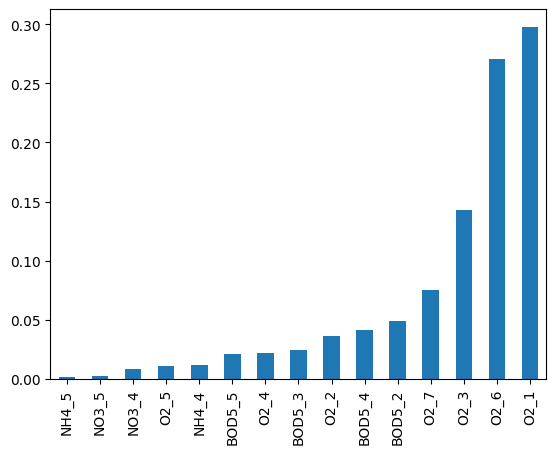

In [125]:
# plot feature importance
coef_sort.plot(kind='bar')
plt.show()

In [126]:
featureLasso = coef_sort.index.tolist()
featureLasso

['NH4_5',
 'NO3_5',
 'NO3_4',
 'O2_5',
 'NH4_4',
 'BOD5_5',
 'O2_4',
 'BOD5_3',
 'O2_2',
 'BOD5_4',
 'BOD5_2',
 'O2_7',
 'O2_3',
 'O2_6',
 'O2_1']

In [127]:
#train-test split
X_train_lasso, X_val_lasso, y_train_lasso, y_val_lasso = train_test_split(X_lasso, y_lasso, test_size=0.2, random_state=42)

In [128]:
#create model
model_lasso = RandomForestRegressor(n_estimators=1000, max_depth=7, n_jobs=-1, random_state=42)

#fit model
model_lasso.fit(X_train_lasso, y_train_lasso)

#predict
prediction_lasso = model_lasso.predict(X_val_lasso)
loss_lasso = mean_squared_error(y_val_lasso, prediction_lasso)
print(f"LassoCV /Random Forest/ has RMSE = {loss_lasso}")

LassoCV /Random Forest/ has RMSE = 1.3008160325406113


In [129]:
# XGBoost uses decision trees as its base learners and combines them sequentially to improve the model’s performance.
# Each new tree is trained to correct the errors made by the previous tree and this process is called boosting.
# It is a type of ensemble learning method that combines multiple weak models to form a stronger model.

#create XGBoost model
model_XGboost = XGBRegressor()

#fit model
model_XGboost.fit(X_train_lasso, y_train_lasso)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [130]:
#predict
prediction_XGboost = model_XGboost.predict(X_val_lasso)
loss_XGboost = mean_squared_error(y_val_lasso, prediction_XGboost)
print(f"LassoCV /XGBoost/ has RMSE = {loss_XGboost}")

LassoCV /XGBoost/ has RMSE = 1.4070634946680314


Text(0, 0.5, 'Loss')

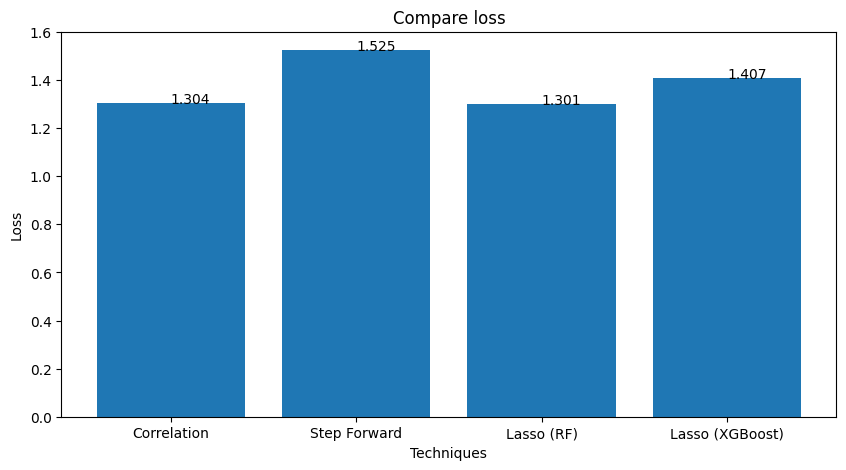

In [131]:
# Function to add value labels on top of bars
def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i])  # Placing text slightly above the bar

loss_y = np.round([loss_corr, loss_sfs, loss_lasso, loss_XGboost], decimals = 3)
loss_x = ['Correlation', 'Step Forward', 'Lasso (RF)', 'Lasso (XGBoost)']

plt.figure(figsize=(10, 5))
plt.bar(loss_x, loss_y)

add_labels(loss_x, loss_y)

plt.title("Compare loss")
plt.xlabel("Techniques")
plt.ylabel("Loss")

Conclusion:

Filter methods do not incorporate a machine learning model in order to determine if a feature is good or bad whereas wrapper methods use a machine learning model and train it the feature to decide if it is essential or not.

Filter methods are much faster compared to wrapper methods as they do not involve training the models. On the other hand, wrapper methods are computationally costly, and in the case of massive datasets, wrapper methods are not the most effective feature selection method to consider.